In [17]:
import sys
import os

SOURCE_PATH = os.path.dirname(os.getcwd())
sys.path.append(SOURCE_PATH)

import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

from utils import Pyutils as pyutils

plt.style.use("bmh")
plt.rcParams["figure.figsize"] = (15,10)

INPUTS_PATH = os.path.join(SOURCE_PATH, "data", "inputs")
OUTPUTS_PATH = os.path.join(SOURCE_PATH, "data", "outputs")
DATASET_NAMES = ["betadgp_covdgp_data", "betadgp_beta2x2_data", "betadgp_data"]
TARGET_NAME = "betas_dgp"
MODEL_TAGS = ["linear_reg", "ffnn"]

In [19]:
all_data = []
model_summary = []
idx = 0
for model_tag in tqdm(MODEL_TAGS,
                      desc="Append all model results"):
    
    DGPS = os.listdir(os.path.join(OUTPUTS_PATH, model_tag))
    for dgp_name in DGPS:
        for ds in DATASET_NAMES:
            
            data = pd.read_csv(os.path.join(OUTPUTS_PATH, model_tag, dgp_name, ds + "_result.csv"))
            data["model"] = model_tag
            data["dgp"] = dgp_name
            data["dataset"] = ds
            
            mse = mean_squared_error(y_true=data["y"],
                                     y_pred=data["pred"])
            mae = mean_absolute_error(y_true=data["y"],
                                      y_pred=data["pred"])

            model_summary_tmp = pyutils.load_pkl(path=os.path.join(OUTPUTS_PATH, model_tag, dgp_name, ds + "_model.pickle"))
            model_summary_tmp["model"] = model_tag
            model_summary_tmp["dgp"] = dgp_name
            model_summary_tmp["number_of_variables"] = int(model_summary_tmp['dgp'].split("_")[1])
            model_summary_tmp["dataset"] = ds
            model_summary_tmp["mse"] = mse
            model_summary_tmp["mae"] = mae
            if model_tag == "linear_reg":
                model_summary_tmp['coef'] = str(tuple(map(tuple, model_summary_tmp['coef']))[0])
            
            model_summary.append(pd.DataFrame(model_summary_tmp, index=[idx]))
            idx += 1
            
            all_data.append(data)
all_data_df = pd.concat(all_data, axis=0)
model_summary_df = pd.concat(model_summary, axis=0)

Append all model results: 100%|██████████| 2/2 [00:21<00:00, 10.58s/it]


In [21]:
all_data_df.head()

,Var1,Var2,y,pred,model,dgp,dataset
0,1,1,0.573050,0.011875,linear_reg,ar1_150_random,betadgp_covdgp_data
1,1,2,0.000000,0.003306,linear_reg,ar1_150_random,betadgp_covdgp_data
2,1,3,0.000000,0.003231,linear_reg,ar1_150_random,betadgp_covdgp_data
3,1,4,0.000000,0.001429,linear_reg,ar1_150_random,betadgp_covdgp_data
4,1,5,-0.167291,0.003565,linear_reg,ar1_150_random,betadgp_covdgp_data


In [32]:
tmp_data = all_data_df.loc[(all_data_df["dgp"] == "ar1_150_random")&
                           (all_data_df["dataset"] == "betadgp_covdgp_data")&
                           (all_data_df["model"] == "linear_reg")]
tmp_data = tmp_data[["y", "pred"]]

<AxesSubplot:xlabel='pred', ylabel='y'>

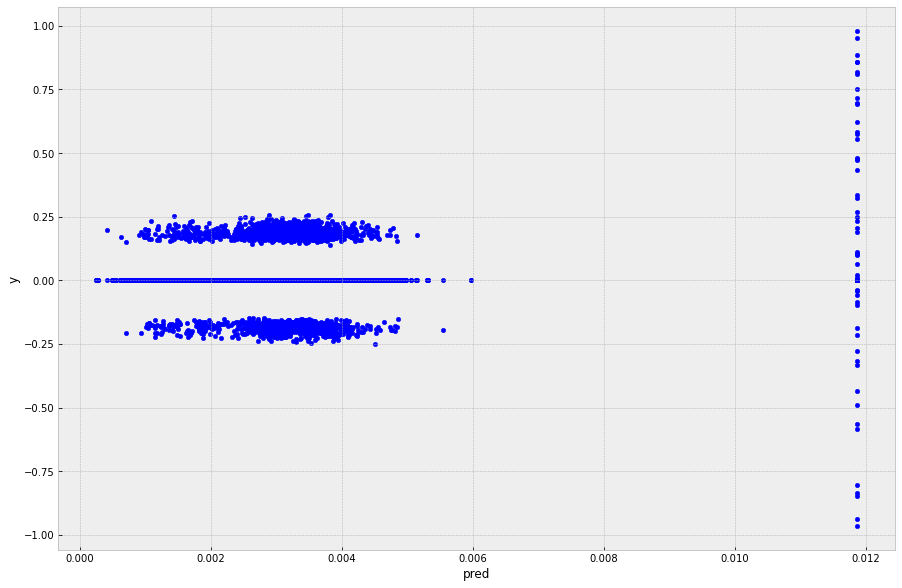

In [34]:
tmp_data.plot.scatter(y="y", x="pred")

### Prediction tree

> 1) y_pred zero AND y_true zero
> 2) y_pred zero BUT y_true not zero
> 3) y_pred not zero AND y_true not zero
> 4) y_pred not zero BUT y_true zero

The errors that we wish to control are 2) and 4), but it seems reasonable to penalize 2) more than 4).

In [47]:
y_true = tmp_data["y"]
y_pred = tmp_data["pred"]

w = 0.1
y_pred_of_nonzeros = np.where(y_true == 0,
                              y_pred - y_pred,
                              y_pred)

# non-zero target predictions are penalized less than the average prediction
loss = np.mean(np.square(y_true - y_pred_of_nonzeros)) + (np.mean(np.square(y_true - y_pred)) * w)
loss

0.004711997630435054

In [57]:
import tensorflow as tf
import tensorflow.keras.metrics as kMetrics

In [60]:
w = 0.1
y_pred_of_nonzeros = tf.where(tf.equal(y_true, 0), y_pred-y_pred, y_pred)
tf.reduce_mean(tf.square(y_true - y_pred_of_nonzeros)) + tf.reduce_mean(tf.square(y_true-y_pred)) * w

<tf.Tensor: id=38, shape=(), dtype=float64, numpy=0.004711997630435055>

In [61]:
def weighted_mean_squared_error(y_true,
                                y_pred,
                                w=0.1):
    
    y_pred_of_nonzeros = tf.where(tf.equal(y_true, 0), y_pred-y_pred, y_pred)
    
    # non-zero target predictions are penalized less than the average prediction
    return tf.reduce_mean(tf.square(y_true - y_pred_of_nonzeros)) + tf.reduce_mean(tf.square(y_true-y_pred)) * w